###Packages

In [ ]:
# import packages
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, auc

###Import data file and look for missing records

In [ ]:
# load dataset
file_path = "spam.data"
df = pd.read_csv(file_path, delimiter=" ")

In [ ]:
# determine if data is missing features' values
missing_records = np.where(pd.isnull(df))
for records in missing_records:
  if records.size > 0:
    print("There is at least one missing features' values")

###Develop Raw, Normalized and Standardized Data

In [ ]:
# raw data
df_raw = df.drop(labels = 'Class', axis = 1 )

# normalization of features
norm_scaler = MinMaxScaler()
normalized = norm_scaler.fit_transform(df.drop(labels = 'Class', axis = 1 ))
df_normalized = pd.DataFrame(normalized, columns = df.drop(labels = 'Class', axis = 1 ).columns)

# standardization of features
standard_scaler = StandardScaler()
standardized = standard_scaler.fit_transform(df.drop(labels = 'Class', axis = 1 ))
df_standardized = pd.DataFrame(standardized, columns = df.drop(labels = 'Class', axis = 1 ).columns)


In [ ]:
def data_selection(selection):

    if selection is "df_raw":
      return df_raw

    if selection is "df_normalized":
      return df_normalized

    if selection is "df_standardized":
      return df_standardized

### Classifiers

####Classifiers: KNN ([REF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)), Random Forest ([REF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)) & Logistic Regression ([REF](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression))

In [ ]:
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier(criterion = 'entropy')
lr_clf = LogisticRegression(max_iter = 10000)

####Soft & Hard Voting Classifiers using KNN, Random Forest & Logistic Regression ([REF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html?highlight=voting#sklearn.ensemble.VotingClassifier))

In [ ]:
v_soft_clf = VotingClassifier(estimators = [('Logistic', lr_clf), ('Random Forest', rf_clf), ('K-Nearest Neighbors', knn_clf)], voting='soft')
v_hard_clf = VotingClassifier(estimators = [('Logistic', lr_clf), ('Random Forest', rf_clf), ('K-Nearest Neighbors', knn_clf)], voting='hard')

####Adaboost w/ Decision Tree Classifier ([REF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier))

In [ ]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy')
adb_clf = AdaBoostClassifier(base_estimator = dt_clf)

###Functions for Classifiers

In [ ]:
def calibration_compare():
    clf_list = [
        (lr_clf, "Logistic"),
        (rf_clf, "Random Forest"),
        (knn_clf, "K-Nearest Neighbors"),
    ]

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(5, 2)
    colors = plt.cm.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, (classifier, name) in enumerate(clf_list):
        classifier.fit(X_train, Y_train)
        display = CalibrationDisplay.from_estimator(
            classifier,
            X_test,
            Y_test,
            n_bins=20,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")

    # Add histogram
    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4,0)]
    for i, (_, name) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=20,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    plt.show()


In [ ]:
def mean_clf(clf, clf_name, iter = 50):

  accuracies = [] # stores accuracies
  bounds_accuracies = [] # 99% confidence interval
  probs = [] # stores score probabilities of the test data
  cms = [] # store components confusion matrices

  print("Classifier:", clf_name)

  for index in tqdm(range(iter), ascii=True, unit=' Sample'):

    # train model using training split
    clf.fit(X_train, Y_train)

    # apply model to test split
    Y_pred = clf.predict(X_test)
    if clf_name in prob_methods_names:
      Y_score = clf.predict_proba(X_test)
    else:
      Y_score = 0

    # store predictions, accuracy and probability scores
    accuracies.append(accuracy_score(Y_test, Y_pred))
    probs.append(Y_score)

    # store components confusion matrix
    cm = confusion_matrix(Y_test, Y_pred, labels=class_labels)
    TN, FP, FN, TP = cm.ravel()
    cms.append([TN, FP, FN, TP])

  mean_accuracies = np.mean(accuracies)
  stdev_accuracies = np.std(accuracies, ddof=1)

  # Lower and Upper Limits 95% Confidence Interval
  bounds_accuracies.append(mean_accuracies - 2.576*(stdev_accuracies/sqrt(iter)))
  bounds_accuracies.append(mean_accuracies + 2.576*(stdev_accuracies/sqrt(iter)))

  mean_probs = np.mean(np.array(probs), axis=0)
  mean_cms = np.mean(np.array(cms), axis=0)

  return iter, accuracies, mean_accuracies, stdev_accuracies, bounds_accuracies, mean_cms, mean_probs

In [ ]:
def show_general_stats(clf_name):

  print("\nSample Size:", iter)
  print("Accuracy Mean:", mean_accuracies)
  print("Accuracy Standard Deviation:", stdev_accuracies)

  TN = mean_cms[0]
  FP = mean_cms[1]
  FN = mean_cms[2]
  TP = mean_cms[3]

  print('\nTN FP FN TP =', TN, FP, FN, TP, "\n")

  cm = np.array([[TN, FP], 
                [FN, TP]])
  
  ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')

  ax.set_title('Mean Confusion Matrix: {}\n\n'.format(clf_name));
  ax.set_xlabel('\nPredicted Label')
  ax.set_ylabel('True Label');

  ax.xaxis.set_ticklabels(['ham','spam'])
  ax.yaxis.set_ticklabels(['ham','spam'])

  plt.show()

  # True Positive Rate TPR = TP/(TP+FN)
  TPR = TP/(TP+FN)
  print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

  # True Negative Rate TNR = TN/(TN+FP)
  TNR = TN/(FP+TN)
  print("True Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

  # False Positive Rate FPR = FP/(FP+TN)
  FPR = FP/(FP+TN)
  print("False Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

  # False Negative Rate FNR = FN/(FN+TP)
  FNR = FN/(FN+TP)
  print("False Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

  # Precision
  PRECISION = TP/(TP+FP)
  print("Precision Rate =",round(PRECISION*100, 4), "%")

  # Recall
  RECALL = TP/(TP+FN)
  print("Recall Rate =",round(RECALL*100, 4), "%\n")

  if clf_name in prob_methods_names:

    # get false and true positive rates
    fpr, tpr, thresholds_roc = roc_curve(Y_test, mean_probs[:,1], pos_label='spam')
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    # get area under the curve
    roc_auc = auc(fpr, tpr)

    # get prec and recall rates
    prec, recall, thresholds_prc = precision_recall_curve(Y_test, mean_probs[:,1], pos_label='spam')
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    # get area under the curve
    pr_auc = auc(recall, prec)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 5)

    ax1.plot(fpr, tpr, lw=1)
    ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
    ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
    ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
    ax1.set_xlim([-.1, 1.1])

    ax2.plot(recall, prec, lw=1)
    ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
    ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
    ax2.set(xlabel = 'Recall', ylabel = 'Precision')
    ax2.set_xlim([-.1, 1.1])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_accuracy_spread(clf_name):

  print('\n')

  accuracies_df = pd.DataFrame(accuracies, columns=['Sample Accuracies'])

  ax = sns.histplot(data=accuracies_df['Sample Accuracies'], bins=30, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5)

  ax.set_title("Accuracies Distribution: {}".format(clf_name), fontsize=14, pad=15)

  plt.show()

  print('\n')

  adj_range = range(sample_size)

  plt.plot(adj_range, [mean_accuracies]*len(adj_range), label='Mean: {}'.format(round(mean_accuracies,4)), linestyle='--')
  plt.plot(adj_range, [bounds_accuracies[0]]*len(adj_range), label='LCL: {}'.format(round(bounds_accuracies[0], 4)), linestyle='-')
  plt.plot(adj_range, [bounds_accuracies[1]]*len(adj_range), label='UCL: {}'.format(round(bounds_accuracies[1],4)), linestyle='-')

  plt.title("99% Confidence Interval for Mean Accuracy: {}".format(clf_name))
  plt.ylabel(f"Accuracies")
  plt.legend(loc="best")

  plt.show()

  print('\n')

  plt.scatter(adj_range, accuracies, s = 2, marker='o', color='black')
  plt.plot(adj_range, [mean_accuracies]*len(adj_range), label='Mean: {}'.format(round(mean_accuracies,4)), linestyle='--')
  plt.plot(adj_range, [bounds_accuracies[0]]*len(adj_range), label='LCL: {}'.format(round(bounds_accuracies[0], 4)), linestyle='-')
  plt.plot(adj_range, [bounds_accuracies[1]]*len(adj_range), label='UCL: {}'.format(round(bounds_accuracies[1],4)), linestyle='-')

  plt.title("Sample Accuracies: {}".format(clf_name))
  plt.ylabel(f"Accuracies")
  plt.xlabel("Samples")
  plt.legend(loc="best")

  plt.show()

In [ ]:
def compare_clfs():

  line_style = ['--', '--',  '--',  '-',  '-', ':']

  for index, mean_acc in enumerate(mean_acc_by_clf):
    plt.plot(split_percentages, mean_acc, line_style[index], marker="o")

  plt.legend(all_methods_names, loc="best")
  plt.title("Mean Accuracies vs Training-Test Splits")
  plt.ylabel(f"Mean Accuracies")
  plt.xlabel("Test Data Percentage")

  plt.show()

###Models

####Set Data Parameters: Raw, Normalized or Standardized

In [ ]:
data_options = "df_standardized" #@param ["df_raw", "df_normalized", "df_standardized"]

X_features_df = data_selection(data_options)
Y_class_labels_df = df['Class']
class_labels = Y_class_labels_df.unique()

print("Maximum Features (N) = {}".format(len(X_features_df.columns)))
print("Records = {} \n".format(len(X_features_df)))
print("The data is set to:", data_options)

print("\nClass Distribution - Pre Split")
print(round((Y_class_labels_df.value_counts()/Y_class_labels_df.shape)*100,4))

Maximum Features (N) = 57
Records = 4601 

The data is set to: df_standardized

Class Distribution - Pre Split
ham     60.5955
spam    39.4045
Name: Class, dtype: float64


####Results

In [ ]:
full_clf_list = [
    (lr_clf, "Logistic"),
    (rf_clf, "Random Forest"),
    (knn_clf, "K-Nearest Neighbors"),
    (v_hard_clf, "Hard Voting/Majority Rule"),
    (v_soft_clf, "Soft Voting/Majority Rule"),
    (adb_clf, "Adaboost w/ Decision Tree"),
]

all_methods_names = ['Logistic',
                       'Random Forest', 
                       'K-Nearest Neighbors', 
                       'Hard Voting/Majority Rule', 
                       'Soft Voting/Majority Rule',  
                       'Adaboost w/ Decision Tree']

prob_methods_names = ['Logistic',
                       'Random Forest', 
                       'K-Nearest Neighbors', 
                       'Soft Voting/Majority Rule',  
                       'Adaboost w/ Decision Tree']

ensemble_methods_names = ["Hard Voting/Majority Rule",
                          "Soft Voting/Majority Rule",
                          "Adaboost w/ Decision Tree"]

split_percentages = [.1, .2, .3, .4, .5, .6, .7, .8, .9] # test percentage
sample_size = 300

mean_acc_by_clf = []
acc = [
       [],[],[],[],[],[],
       ]

for index, classifier in enumerate(tqdm(full_clf_list, ascii=True, unit=' Classifier')):

  for split_percentage in split_percentages:

    print(classifier[1])
    print("Sample Size:", sample_size)
    print("TestSplit:", split_percentage)
    print('\n')

    # split data
    X_train, X_test, Y_train, Y_test = train_test_split(X_features_df, 
                                                      Y_class_labels_df, 
                                                      test_size=split_percentage, 
                                                      stratify=Y_class_labels_df)
    
    if classifier[1] is "Soft Voting/Majority Rule":
      #Calibration Comparison 
      calibration_compare()
      print("\n")

    iter, accuracies, mean_accuracies, stdev_accuracies, bounds_accuracies, mean_cms, mean_probs = mean_clf(classifier[0], classifier[1], sample_size)
    acc[index].append(mean_accuracies)

    if classifier[1] in ensemble_methods_names:
      show_general_stats(classifier[1])
      plot_accuracy_spread(classifier[1])

    print('\n')

  mean_acc_by_clf.append(acc[index])
  print ("------------------ \n")

compare_clfs()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#print('Mean of Mean Performance\n')
#for index, classifier in enumerate(full_clf_list):
  #avg_acc = np.mean(mean_acc_by_clf[index])
  #print(classifier[1])
  #print("Accuracy: ",round(avg_acc,6)*100, "%\n")

print('----Best Performance----\n')
for index, classifier in enumerate(full_clf_list):
  max_acc = max(mean_acc_by_clf[index])
  max_acc_index = mean_acc_by_clf[index].index(max_acc)
  print(classifier[1])
  print("Test Split:", split_percentages[max_acc_index]*100, "%")
  print("Accuracy: ",round(max_acc,6)*100, "%\n")

print('----Worst Performance----\n')
for index, classifier in enumerate(full_clf_list):
  min_acc = min(mean_acc_by_clf[index])
  min_acc_index = mean_acc_by_clf[index].index(min_acc)
  print(classifier[1])
  print("Test Split:", split_percentages[min_acc_index]*100, "%")
  print("Accuracy: ",round(min_acc,6)*100, "%\n")

----Best Performance----

Logistic
Test Split: 30.0 %
Accuracy:  93.2657 %

Random Forest
Test Split: 10.0 %
Accuracy:  95.9653 %

K-Nearest Neighbors
Test Split: 20.0 %
Accuracy:  92.5081 %

Hard Voting/Majority Rule
Test Split: 40.0 %
Accuracy:  94.4313 %

Soft Voting/Majority Rule
Test Split: 10.0 %
Accuracy:  94.85759999999999 %

Adaboost w/ Decision Tree
Test Split: 30.0 %
Accuracy:  94.2732 %

----Worst Performance----

Logistic
Test Split: 80.0 %
Accuracy:  91.035 %

Random Forest
Test Split: 90.0 %
Accuracy:  92.6515 %

K-Nearest Neighbors
Test Split: 90.0 %
Accuracy:  84.3999 %

Hard Voting/Majority Rule
Test Split: 90.0 %
Accuracy:  91.8715 %

Soft Voting/Majority Rule
Test Split: 80.0 %
Accuracy:  92.6714 %

Adaboost w/ Decision Tree
Test Split: 90.0 %
Accuracy:  85.5111 %



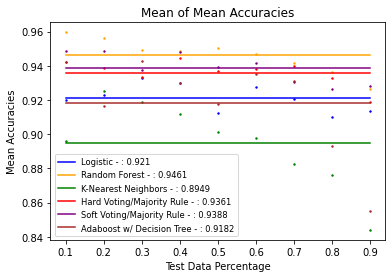

In [ ]:
print('\n')
plt_colors = ['blue',
              'orange',
              'green',
              'red',
              'purple',
              'brown',]
for index, classifier in enumerate(full_clf_list):
  mean_of_mean = np.mean(mean_acc_by_clf[index])
  plt.scatter(split_percentages, mean_acc_by_clf[index], s = 2, marker='o', color=plt_colors[index])
  plt.plot(split_percentages, [mean_of_mean]*len(split_percentages), 
           label='{} - : {}'.format(classifier[1], round(mean_of_mean,4)), 
           linestyle='-',
           color=plt_colors[index])

plt.title("Mean of Mean Accuracies")
plt.ylabel(f"Mean Accuracies")
plt.xlabel("Test Data Percentage")
plt.legend(loc="best", fontsize = 'small')
plt.show()